In [31]:
import sys
import pathlib
import re
import pprint as pp

sys.path.append("..")

from parse_concept_net import ParseConceptNet
from pycorenlp import StanfordCoreNLP
from collections import defaultdict
from ordered_set import OrderedSet

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [45]:
# with open('../Samples/mary.txt', 'r') as file:
#     story = file.read().lower()
story = 'Mary is cycling with her bicycle. She enjoys bicycling on the bike. Alice however drives a car. But Alice also owns a bike and rides it often'

print(story)

Mary is cycling with her bicycle. She enjoys bicycling on the bike. Alice however drives a car. But Alice also owns a bike and rides it often


In [46]:
nlp = StanfordCoreNLP('http://localhost:9000')
output = nlp.annotate(story, properties={
    'annotators': 'pos',
    'outputFormat': 'json'
})

tokenized = [[(word['word'], word['pos']) for word in sentence['tokens']] for sentence in output['sentences']]
print(tokenized)

[[('Mary', 'NNP'), ('is', 'VBZ'), ('cycling', 'NN'), ('with', 'IN'), ('her', 'PRP$'), ('bicycle', 'NN'), ('.', '.')], [('She', 'PRP'), ('enjoys', 'VBZ'), ('bicycling', 'NN'), ('on', 'IN'), ('the', 'DT'), ('bike', 'NN'), ('.', '.')], [('Alice', 'NNP'), ('however', 'RB'), ('drives', 'VBZ'), ('a', 'DT'), ('car', 'NN'), ('.', '.')], [('But', 'CC'), ('Alice', 'NNP'), ('also', 'RB'), ('owns', 'VBZ'), ('a', 'DT'), ('bike', 'NN'), ('and', 'CC'), ('rides', 'NNS'), ('it', 'PRP'), ('often', 'RB')]]


In [47]:
pcn = ParseConceptNet(False)

similar_words = defaultdict(lambda: defaultdict(lambda: 0))
similar_sentences = defaultdict(lambda: defaultdict(lambda: 0))

vocabulary = OrderedSet()

for i, sentence in enumerate(tokenized):
    for word, pos in sentence:
        for j, other_sentence in enumerate(tokenized):
            if i != j:
                for other_word, other_pos in other_sentence:
                    if word != other_word and pos == other_pos:
                        similarity = pcn.compare_words(word, other_word)
                        if similarity > 0:
                            vocabulary.add(word)
                            vocabulary.add(other_word)
                            similar_words[word][other_word] = similarity
                            similar_sentences[i][j] += similarity

In [57]:
WEIGHT_SCALE = 10

def pp_print_links_dict(links_dict):
    pp.pprint({i: dict(links) for i, links in links_dict.items()})

def links_dict_to_adjacency_mat(links_dict, keys):
    adjacency_mat = []
    for key in keys:
        node_weights = [int(WEIGHT_SCALE * links_dict[key][other_key]) for other_key in keys]
        adjacency_mat.append(node_weights)
    return adjacency_mat
        
# pp_print_links_dict(similar_words)
# pp_print_links_dict(similar_sentences)

word_adjacency_mat = links_dict_to_adjacency_mat(similar_words, vocabulary)
sentence_adjacency_mat = links_dict_to_adjacency_mat(similar_sentences, range(len(tokenized)))

[80, 84, 18, 34]


In [49]:
def plot_text_relationship_map(adjacency_mat, title, labels=None):
    G = nx.from_numpy_matrix(np.matrix(adjacency_mat), create_using=nx.DiGraph)
    layout = nx.circular_layout(G)
    nx.draw(G, layout)
    nx.draw_networkx_labels(G, pos=layout, labels=labels)
    nx.draw_networkx_edge_labels(G, pos=layout)
    plt.title(title)
    plt.show()

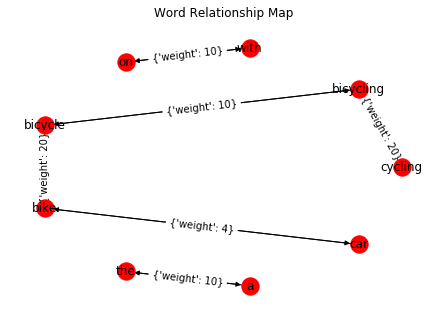

In [50]:
labels = {i: vocabulary[i] for i in range(len(vocabulary))}
plot_text_relationship_map(word_adjacency_mat, 'Word Relationship Map', labels) # TODO add word labels

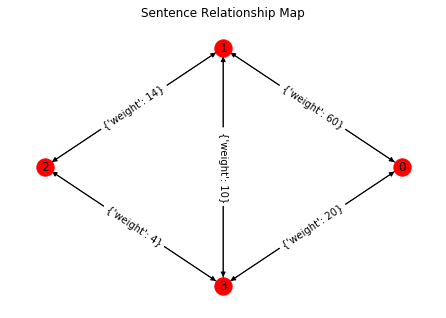

In [51]:
plot_text_relationship_map(sentence_adjacency_mat, 'Sentence Relationship Map')

In [93]:
def order_sentences_by_importance(adjacency_mat, story):
    weights_sum = np.array(list(map(sum, sentence_adjacency_mat)))
    importance_ordering = np.argsort(-weights_sum)
    sentences = [sentence.strip() for sentence in story.split('.')]
    ordered_sentences = [sentences[i] + '.' for i in importance_ordering]
    return list(zip(ordered_sentences, sorted(weights_sum, reverse=True)))

ordered_sentences = order_sentences_by_importance(sentence_adjacency_mat, story)
pp.pprint(ordered_sentences)

[('She enjoys bicycling on the bike.', 84),
 ('Mary is cycling with her bicycle.', 80),
 ('But Alice also owns a bike and rides it often.', 34),
 ('Alice however drives a car.', 18)]


In [95]:
def homogenize_story():
    pass